In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup
import re

# Header and URL
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/apa#search=2~gallery~0'
raw = requests.get(url, headers=header)

# Parse the HTML
bsObj = soup(raw.content, 'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

housing_types = ['apartment', 'house', 'home', 'condo', 'duplex', 'townhouse', 'studio', 'loft', 'cottage', 'basement', 'room', 'suite']
type_pattern = '|'.join([f"{ht}s?" for ht in housing_types])  # Match both singular & plural



In [2]:
data = []
for k in range(len(listings)):
    try:
        title = listings[k].find('div', class_='title').get_text(strip=True).lower()
        price = listings[k].find('div', class_='price').get_text(strip=True) if listings[k].find('div', class_='price') else "N/A"
        link = listings[k].find('a', href=True)['href']
        full_link = link if link.startswith('http') else "https://charlottesville.craigslist.org" + link

        # Detect type of home
        match = re.search(type_pattern, title)
        type_of_home = match.group(0).rstrip('s') if match else 'missing'

        data.append({'title': title, 'price': price, 'link': full_link, 'type_of_home': type_of_home})
    except Exception as e:
        print(f"Error processing a listing: {e}")

# Create DataFrame
df = pd.DataFrame(data)

In [3]:
# checks the title
df['title'].head(10)

,title
0,nice home in belmont
1,mountain ridge apartments
2,"steps to uva single fam 3br, 1 ba brick home"
3,quiet 2br gem minutes from downtown cville (no...
4,3br home with fireplace – ideal location & com...
5,studio apartment for single professional inclu...
6,do you need help loading or unloading your truck
7,"@!@this updated 2-bedroom, 1-bath house blends..."
8,$940 / 2b2b / 1390 sqft! luxury on budget
9,one bedroom /one bath cottage with beautiful m...


In [4]:
# Recalculate price per sqft
df['sqft'] = df['title'].str.extract(r'(\d{2,5})\s*(sq.?ft|sf|ft²|ft\^2)?', expand=False)[0]
df['sqft'] = pd.to_numeric(df['sqft'], errors='coerce')

# Clean price column
df['price_clean'] = pd.to_numeric(df['price'].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')

df['price_per_sqft'] = df['price_clean'] / df['sqft']

# Recalculate logs after correct sqft
df['log_price'] = np.log(df['price_clean'].replace(0, np.nan))
df['log_sqft'] = np.log(df['sqft'].replace(0, np.nan))
df['log_price'] = df['log_price'].replace([np.inf, -np.inf], np.nan)
df['log_sqft'] = df['log_sqft'].replace([np.inf, -np.inf], np.nan)

df.head(10)

,title,price,link,type_of_home,sqft,price_clean,price_per_sqft,log_price,log_sqft
0,nice home in belmont,$0,https://charlottesville.craigslist.org/apa/d/c...,home,NaN,0,NaN,NaN,NaN
1,mountain ridge apartments,"$1,375",https://charlottesville.craigslist.org/apa/d/s...,apartment,NaN,1375,NaN,7.226209,NaN
2,"steps to uva single fam 3br, 1 ba brick home","$2,775",https://charlottesville.craigslist.org/apa/d/c...,home,NaN,2775,NaN,7.928406,NaN
3,quiet 2br gem minutes from downtown cville (no...,"$1,545",https://charlottesville.craigslist.org/apa/d/c...,missing,NaN,1545,NaN,7.342779,NaN
4,3br home with fireplace – ideal location & com...,"$2,095",https://charlottesville.craigslist.org/apa/d/c...,home,NaN,2095,NaN,7.647309,NaN
5,studio apartment for single professional inclu...,"$1,100",https://charlottesville.craigslist.org/apa/d/c...,studio,NaN,1100,NaN,7.003065,NaN
6,do you need help loading or unloading your truck,$65,https://charlottesville.craigslist.org/apa/d/c...,missing,NaN,65,NaN,4.174387,NaN
7,"@!@this updated 2-bedroom, 1-bath house blends...",$850,https://charlottesville.craigslist.org/apa/d/c...,room,NaN,850,NaN,6.745236,NaN
8,$940 / 2b2b / 1390 sqft! luxury on budget,$940,https://charlottesville.craigslist.org/apa/d/c...,missing,940.0,940,1.0,6.845880,6.84588
9,one bedroom /one bath cottage with beautiful m...,$800,https://charlottesville.craigslist.org/apa/d/m...,room,NaN,800,NaN,6.684612,NaN


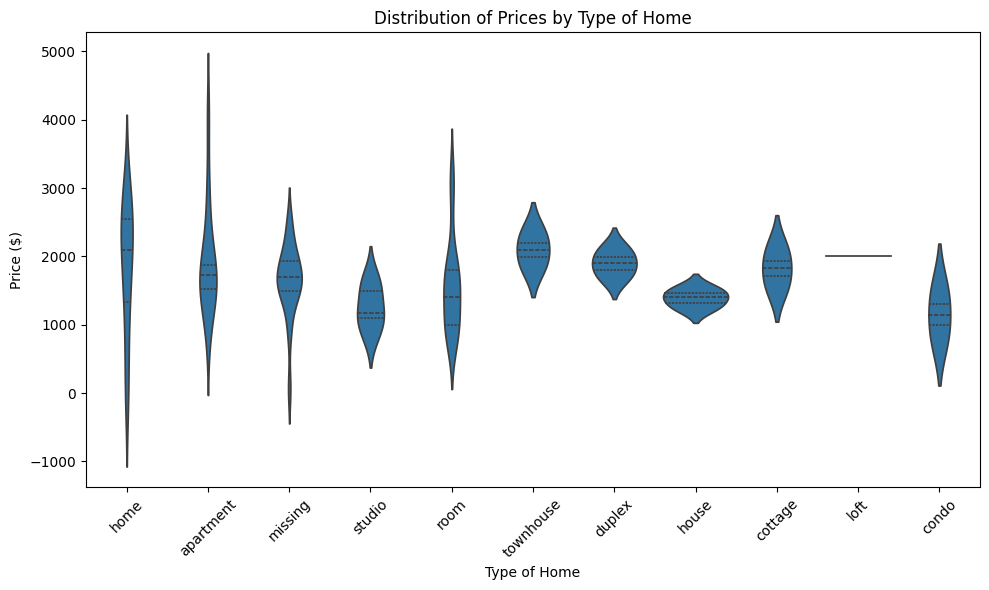

In [5]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x='type_of_home', y='price_clean', inner='quartile')
plt.xticks(rotation=45)
plt.title('Distribution of Prices by Type of Home')
plt.xlabel('Type of Home')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()


In [6]:
# Price by house type:
df.loc[:, ['price_clean', 'type_of_home']].groupby('type_of_home').describe()


price_clean                                                    \
                   count         mean         std     min      25%     50%   
type_of_home                                                                 
apartment           14.0  1915.857143  785.944200   900.0  1525.00  1724.5   
condo                2.0  1150.000000  424.264069   850.0  1000.00  1150.0   
cottage              2.0  1825.000000  318.198052  1600.0  1712.50  1825.0   
duplex               3.0  1899.333333  200.500208  1699.0  1799.00  1899.0   
home                16.0  1857.062500  935.374112     0.0  1335.00  2097.5   
house                3.0  1391.666667  137.689264  1250.0  1325.00  1400.0   
loft                 1.0  2000.000000         NaN  2000.0  2000.00  2000.0   
missing             39.0  1644.384615  529.236322    65.0  1499.00  1695.0   
room                35.0  1561.600000  686.920759   735.0   995.00  1400.0   
studio               5.0  1260.000000  328.157736   850.0  1100.00  1175.0   
townhouse            2.0  2099.500000  283.549819  1899.0  1999.25  2099.5   

                               
                  75%     max  
type_of_home                   
apartment     1874.25  4050.0  
condo         1300.00  1450.0  
cottage       1937.50  2050.0  
duplex        1999.50  2100.0  
home          2545.00  2999.0  
house         1462.50  1525.0  
loft          2000.00  2000.0  
missing       1940.00  2500.0  
room          1799.50  3195.0  
studio        1500.00  1675.0  
townhouse     2199.75  2300.0

In [7]:
df.loc[df['type_of_home'] == 'apartment', :]


,title,price,link,type_of_home,sqft,price_clean,price_per_sqft,log_price,log_sqft
1,mountain ridge apartments,"$1,375",https://charlottesville.craigslist.org/apa/d/s...,apartment,NaN,1375,NaN,7.226209,NaN
12,charming downtown orange apartment for rent,"$1,500",https://charlottesville.craigslist.org/apa/d/w...,apartment,NaN,1500,NaN,7.313220,NaN
22,2000 marchant #3 stunning 2bd/2bath apartment,"$2,500",https://charlottesville.craigslist.org/apa/d/c...,apartment,2000.0,2500,1.250000,7.824046,7.600902
25,luxury downtown charlottesville apartment - mo...,"$1,899",https://charlottesville.craigslist.org/apa/d/c...,apartment,NaN,1899,NaN,7.549083,NaN
27,101 westpark dr 4br apartment- close to darden...,"$2,950",https://charlottesville.craigslist.org/apa/d/c...,apartment,101.0,2950,29.207921,7.989560,4.615121
32,3br apartment near uva campus! available now! ...,"$1,800",https://charlottesville.craigslist.org/apa/d/c...,apartment,500.0,1800,3.600000,7.495542,6.214608
39,wertland apartments - best location & best pri...,"$4,050",https://charlottesville.craigslist.org/apa/d/c...,apartment,NaN,4050,NaN,8.306472,NaN
44,"secluded apartment on twenty-acre estate, 15 m...","$1,400",https://charlottesville.craigslist.org/apa/d/c...,apartment,15.0,1400,93.333333,7.244228,2.708050
83,comyn hall apartment | available now!,"$1,799",https://charlottesville.craigslist.org/apa/d/c...,apartment,NaN,1799,NaN,7.494986,NaN
85,live at mcintire plaza apartments!,"$1,699",https://charlottesville.craigslist.org/apa/d/c...,apartment,NaN,1699,NaN,7.437795,NaN


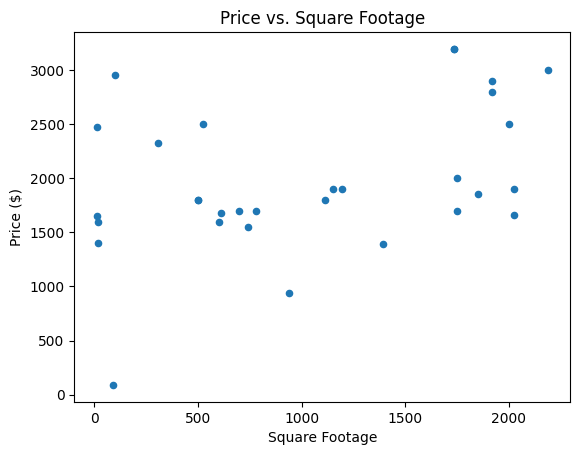

In [8]:
# Scatter plot: Square footage vs. Price
df.plot.scatter(x='sqft', y='price_clean', title='Price vs. Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Price ($)')
plt.show()


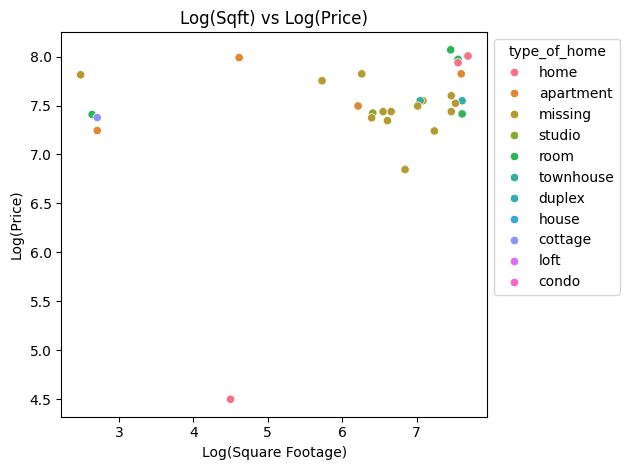

Covariance matrix:
           log_price  log_sqft
log_price   0.356295  0.262972
log_sqft    0.262972  2.683962

Correlation matrix:
           log_price  log_sqft
log_price   1.000000  0.258255
log_sqft    0.258255  1.000000


In [9]:
# Safely calculate log(price) and log(sqft)
df['log_price'] = np.log(df['price_clean'].replace(0, np.nan))
df['log_sqft'] = np.log(df['sqft'].replace(0, np.nan))

# Drop infinite values
df['log_price'] = df['log_price'].replace([np.inf, -np.inf], np.nan)
df['log_sqft'] = df['log_sqft'].replace([np.inf, -np.inf], np.nan)

ax = sns.scatterplot(data=df, x='log_sqft', y='log_price', hue='type_of_home')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Log(Sqft) vs Log(Price)')
plt.xlabel('Log(Square Footage)')
plt.ylabel('Log(Price)')
plt.tight_layout()
plt.show()

print("Covariance matrix:")
print(df.loc[:, ['log_price', 'log_sqft']].cov())

print("\nCorrelation matrix:")
print(df.loc[:, ['log_price', 'log_sqft']].corr())


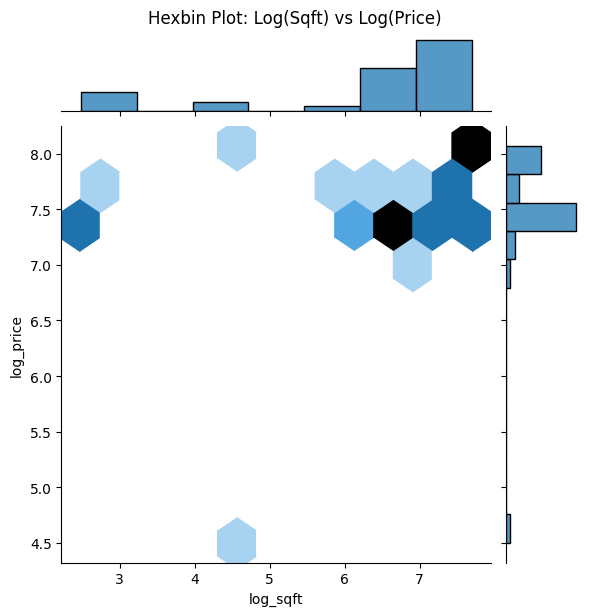

In [10]:
df_clean = df[['log_sqft', 'log_price']].dropna()

sns.jointplot(data=df_clean, x='log_sqft', y='log_price', kind='hex')
plt.suptitle('Hexbin Plot: Log(Sqft) vs Log(Price)', y=1.02)
plt.show()


In [11]:
df.head()

,title,price,link,type_of_home,sqft,price_clean,price_per_sqft,log_price,log_sqft
0,nice home in belmont,$0,https://charlottesville.craigslist.org/apa/d/c...,home,NaN,0,NaN,NaN,NaN
1,mountain ridge apartments,"$1,375",https://charlottesville.craigslist.org/apa/d/s...,apartment,NaN,1375,NaN,7.226209,NaN
2,"steps to uva single fam 3br, 1 ba brick home","$2,775",https://charlottesville.craigslist.org/apa/d/c...,home,NaN,2775,NaN,7.928406,NaN
3,quiet 2br gem minutes from downtown cville (no...,"$1,545",https://charlottesville.craigslist.org/apa/d/c...,missing,NaN,1545,NaN,7.342779,NaN
4,3br home with fireplace – ideal location & com...,"$2,095",https://charlottesville.craigslist.org/apa/d/c...,home,NaN,2095,NaN,7.647309,NaN


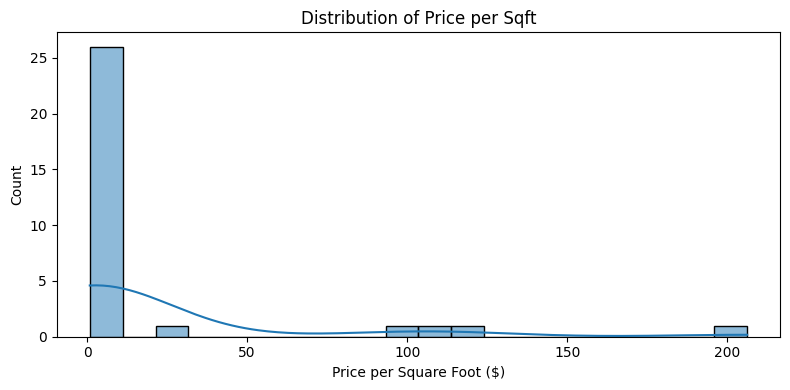

In [14]:
plt.figure(figsize=(8,4))
sns.histplot(df['price_per_sqft'].dropna(), bins=20, kde=True)
plt.title('Distribution of Price per Sqft')
plt.xlabel('Price per Square Foot ($)')
plt.tight_layout()
plt.show()


In this lab, I analyzed housing listings from Craigslist in Charlottesville by scraping summary data such as title, price, square footage, and home type. Using Python requests and BeautifulSoup, I scraped data including titles, prices, square footage, and inferred home types (e.g., apartment, house, studio, etc.) from the search results page.
After cleaning and processing the data, i got the derived features like price per sq ft and log transformed price and sq footage to normalize skewed distributions which let us have more insightful visualizaiton and comparasion across listings.

The violin plot showed that apartments and townhouses are usually more expensive, with a lot of variation in apartment prices and some studios. Other types like cottages, lofts, and condos had fewer listings but more consistent pricing, while listings labeled as just “home” or “missing” had the most variability, likely because of unclear titles. The scatterplot of square footage vs. price showed only a weak trend, suggesting that price isnt based on size alone. But the log-log scatterplot and hexbin plot made the relationship clearer, showing a more linear pattern with a moderate positive correlation between log(price) and log(sqft). Lastly, the histogram of price per square foot showed that most listings fall between $1 to $5 per sqft, with a few outliers above $100, likely due to very small or overpriced units.